# Tawfiq Moharaq
https://www.linkedin.com/in/tawfiq-moharaq-1a37ba2a3/recent-activity/all/

In [9]:
import os
import random
import warnings
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix
)
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)


In [10]:
#  Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [11]:
# Domain vocabulary

majors_keywords: Dict[str, List[str]] = {
    'Computer Science': [
        'python','computer','programming','software','algorithms','ai',
        'artificial intelligence','cloud computing','cybersecurity','machine learning'
    ],
    'Data Science': [
        'data','machine learning','statistics','deep learning','analysis',
        'big data','data mining','blockchain','data visualization'
    ],
    'Business': [
        'marketing','business','finance','management','entrepreneurship',
        'sales','leadership','strategy','digital marketing','e-commerce'
    ],
    'Health': [
        'health','medical','biology','care','nursing','biotechnology',
        'healthcare','public health','medicine','telemedicine','clinical research'
    ],
    'Engineering': [
        'engineering','mechanics','design','electronics','robotics',
        'civil engineering','electrical engineering','mechanical engineering','renewable energy'
    ]
}
MAJORS = list(majors_keywords.keys())

EVENT_TEMPLATES = [
    "Intro to {}", "{} Workshop", "{} Bootcamp", "{} Seminar",
    "{} for Beginners", "Advanced {}", "{} Masterclass", "{} Applications",
    "{} in Practice", "Trends in {}", "Practical {}", "{} for Startups",
    "{} & Case Studies", "{} Fundamentals", "{} Conference", "{} Summit", "{} Hackathon",
]


In [12]:
# Synthetic but more realistic data

def generate_students(num_students: int = 600) -> pd.DataFrame:
    """Create synthetic students with major + 2-3 interests; sometimes add off-major noise."""
    rows = []
    for i in range(1, num_students + 1):
        major = random.choice(MAJORS)
        base_pool = majors_keywords[major]
        k = random.choice([2, 3])
        interests = random.sample(base_pool, k=k)
        if random.random() < 0.25:  # 25% chance add one off-major interest
            other_major = random.choice([m for m in MAJORS if m != major])
            interests.append(random.choice(majors_keywords[other_major]))
        rows.append({"StudentID": f"S{i}", "Major": major, "Interests": interests})
    return pd.DataFrame(rows)

def generate_events(num_events: int = 180) -> pd.DataFrame:
    """Create events with paraphrased titles; sometimes mix two keywords."""
    rows = []
    for i in range(num_events):
        seed_major = random.choice(MAJORS)
        seed_kw = random.choice(majors_keywords[seed_major])
        template = random.choice(EVENT_TEMPLATES)
        if random.random() < 0.30:
            other_major = random.choice(MAJORS)
            other_kw = random.choice(majors_keywords[other_major])
            title = template.format(f"{seed_kw.title()} & {other_kw.title()}")
        else:
            title = template.format(seed_kw.title())
        month = random.randint(5, 10)
        day = random.randint(1, 28)
        date = f"2025-{month:02d}-{day:02d}"
        rows.append({"EventID": f"E{i}", "EventTitle": title, "EventDate": date})
    return pd.DataFrame(rows)

students = generate_students(600)
events = generate_events(180)


In [13]:
# Labeling via semantic similarity + small noise
# -------------------------------
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def label_pair(student_interests: List[str], event_title: str,
               pos_thresh: float = 0.42, noise_flip_prob: float = 0.03) -> int:
    """
    Label (student, event) using cosine similarity between embeddings.
    If sim >= pos_thresh -> 1 else 0. Add small noise to simulate imperfect labels.
    """
    interests_text = " / ".join(student_interests)
    v1 = embedder.encode(interests_text, normalize_embeddings=True)
    v2 = embedder.encode(event_title, normalize_embeddings=True)
    sim = float(np.dot(v1, v2))  # cosine (because normalized)
    y = 1 if sim >= pos_thresh else 0
    if random.random() < noise_flip_prob:
        y = 1 - y
    return y

def build_dataset(students_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    """Sample ~25 events per student to keep size reasonable."""
    rows = []
    for _, s in students_df.iterrows():
        sampled_events = events_df.sample(n=min(25, len(events_df)), random_state=SEED)
        for _, e in sampled_events.iterrows():
            y = label_pair(s["Interests"], e["EventTitle"])
            rows.append({
                "StudentID": s["StudentID"],
                "Major": s["Major"],
                "StudentInterests": " ".join(s["Interests"]),
                "EventID": e["EventID"],
                "EventTitle": e["EventTitle"],
                "EventDate": e["EventDate"],
                "Label": y
            })
    return shuffle(pd.DataFrame(rows), random_state=SEED).reset_index(drop=True)

dataset = build_dataset(students, events)
print(" Dataset shape:", dataset.shape)
print(" Positive rate:", round(dataset['Label'].mean(), 3))


 Dataset shape: (15000, 7)
 Positive rate: 0.116


In [14]:
#  Embeddings as features

combined_texts = (dataset["StudentInterests"] + " [SEP] " + dataset["EventTitle"]).tolist()
X = embedder.encode(combined_texts, normalize_embeddings=False, batch_size=256, show_progress_bar=True)
y = dataset["Label"].values


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

In [15]:
#  Split: train / valid / test  (avoid leakage)
# -------------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
# validation from original train (before SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
)

# Balance TRAIN ONLY with SMOTE
smote = SMOTE(random_state=SEED)
X_tr_bal, y_tr_bal = smote.fit_resample(X_tr, y_tr)
print(" Train (pre-SMOTE):", X_tr.shape[0], "-> after SMOTE:", X_tr_bal.shape[0])
print(" Valid:", X_val.shape[0], " | Test:", X_test.shape[0])


 Train (pre-SMOTE): 9600 -> after SMOTE: 16964
 Valid: 2400  | Test: 3000


In [16]:
#  Train three models

models = {
    "XGBoost": XGBClassifier(
        n_estimators=350, max_depth=6, learning_rate=0.08,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss",
        random_state=SEED, n_jobs=-1
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000, class_weight="balanced", n_jobs=None
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=2,
        class_weight="balanced", random_state=SEED, n_jobs=-1
    )
}

def find_best_threshold(y_true: np.ndarray, proba: np.ndarray) -> Tuple[float, float]:
    """Search threshold in [0,1] that maximizes F1 on validation."""
    best_t, best_f1 = 0.5, -1.0
    for t in np.linspace(0.05, 0.95, 19):
        y_hat = (proba >= t).astype(int)
        f1 = f1_score(y_true, y_hat, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

results = []
fitted = {}
thresholds = {}

for name, clf in models.items():
    clf.fit(X_tr_bal, y_tr_bal)
    fitted[name] = clf

    # choose threshold on VALID
    val_proba = clf.predict_proba(X_val)[:, 1]
    t_opt, f1_val = find_best_threshold(y_val, val_proba)
    thresholds[name] = t_opt

    # evaluate on TEST using t_opt
    test_proba = clf.predict_proba(X_test)[:, 1]
    test_pred = (test_proba >= t_opt).astype(int)

    precision = precision_score(y_test, test_pred, zero_division=0)
    recall = recall_score(y_test, test_pred, zero_division=0)
    f1 = f1_score(y_test, test_pred, zero_division=0)
    roc = roc_auc_score(y_test, test_proba)
    pr_auc = average_precision_score(y_test, test_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()

    results.append({
        "Model": name, "Threshold": round(t_opt, 3),
        "Precision": round(precision, 3), "Recall": round(recall, 3),
        "F1": round(f1, 3), "ROC_AUC": round(roc, 3),
        "PR_AUC": round(pr_auc, 3), "TP": tp, "FP": fp, "FN": fn, "TN": tn
    })

results_df = pd.DataFrame(results).sort_values("PR_AUC", ascending=False).reset_index(drop=True)
print("\n Model Comparison (sorted by PR_AUC):")
print(results_df)

best_row = results_df.iloc[0]
best_name = best_row["Model"]
best_model = fitted[best_name]
best_thr = float(thresholds[best_name])

print(f"\n Selected BEST model: {best_name} | Threshold={best_thr:.3f}")




 Model Comparison (sorted by PR_AUC):
                Model  Threshold  Precision  Recall     F1  ROC_AUC  PR_AUC  \
0             XGBoost        0.5      0.645   0.562  0.600    0.842   0.639   
1        RandomForest        0.4      0.571   0.607  0.589    0.838   0.606   
2  LogisticRegression        0.7      0.579   0.493  0.533    0.826   0.565   

    TP   FP   FN    TN  
0  196  108  153  2543  
1  212  159  137  2492  
2  172  125  177  2526  

 Selected BEST model: XGBoost | Threshold=0.500


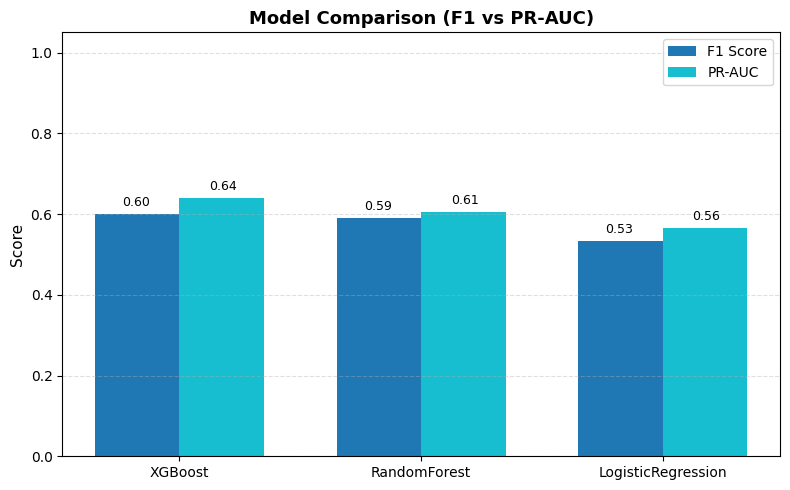

In [17]:
# quick bar plot of three models (F1 & PR_AUC)

plt.figure(figsize=(8, 5))

# Custom colors (harmonious palette)
f1_color = "#1f77b4"      # Deep blue
pr_color = "#17becf"      # Soft turquoise

# Plot the bars side-by-side with small offset for clarity
x = np.arange(len(results_df["Model"]))
width = 0.35

plt.bar(x - width/2, results_df["F1"], width, label="F1 Score", color=f1_color)
plt.bar(x + width/2, results_df["PR_AUC"], width, label="PR-AUC", color=pr_color)

# Labels and title
plt.xticks(x, results_df["Model"])
plt.ylim(0, 1.05)
plt.title("Model Comparison (F1 vs PR-AUC)", fontsize=13, fontweight="bold")
plt.ylabel("Score", fontsize=11)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Annotate bar values on top
for i, (f1, pr) in enumerate(zip(results_df["F1"], results_df["PR_AUC"])):
    plt.text(i - 0.18, f1 + 0.02, f"{f1:.2f}", color="black", ha="center", fontsize=9)
    plt.text(i + 0.18, pr + 0.02, f"{pr:.2f}", color="black", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


**Overall Conclusion**

🔹 XGBoost is the best model — it provides the most balanced performance between precision and recall.

🔹 Random Forest performs decently but tends to generate more false positives (less precise).

🔹 Logistic Regression works fine as a simple baseline but struggles with more complex text interactions.

In [18]:
# Smart notifier using BEST model

def notify_students_about_event(
    event_title: str,
    event_date: str,
    students_df: pd.DataFrame,
    model,
    threshold: float,
    top_k: int = 200,
    return_top_k_if_empty: bool = True
) -> pd.DataFrame:
    """
    Rank all students by model probability for a given event.
    Returns those >= threshold; if none, optionally return top_k highest.
    Always returns a DataFrame with fixed columns.
    """
    if students_df.empty:
        return pd.DataFrame(columns=[
            "StudentID","Major","Interests","EventTitle","EventDate","Probability","Notification"
        ])

    # Batch-encode features for speed
    features_texts = (students_df["Interests"].apply(lambda xs: " ".join(xs)) +
                      " [SEP] " + event_title)
    X_feats = embedder.encode(features_texts.tolist(), normalize_embeddings=False, batch_size=256)
    probs = model.predict_proba(X_feats)[:, 1]

    rows = []
    for (idx, s), p in zip(students_df.iterrows(), probs):
        rows.append({
            "StudentID": s["StudentID"],
            "Major": s["Major"],
            "Interests": s["Interests"],
            "EventTitle": event_title,
            "EventDate": event_date,
            "Probability": float(round(p, 4)),
            "Notification": f" New Event: {event_title} on {event_date}"
        })

    df = pd.DataFrame(rows).sort_values("Probability", ascending=False)
    df_thr = df[df["Probability"] >= threshold]

    if df_thr.empty and return_top_k_if_empty:
        return df.head(min(top_k, len(df))).reset_index(drop=True)
    return df_thr.head(min(top_k, len(df_thr))).reset_index(drop=True)


In [22]:
# User input demo on BEST model

def safe_input(prompt: str, default: str = "") -> str:
    try:
        s = input(prompt).strip()
        return s or default
    except Exception:
        return default

print("\nDemo on BEST model (user input)")
user_title = safe_input("Enter event title (default: 'Healthcare Data Analytics Workshop'): ",
                        "Healthcare Data Analytics Workshop")
user_date = safe_input("Enter event date YYYY-MM-DD (default: 2025-06-15): ", "2025-06-15")

notifications = notify_students_about_event(
    user_title, user_date, students, best_model, best_thr, top_k=200, return_top_k_if_empty=True
)
print("\n Notifications (Top 10):")
print(notifications.head(10))
print(f"Total notified: {len(notifications)}")


 Demo on BEST model (user input)
Enter event title (default: 'Healthcare Data Analytics Workshop'): Ai
Enter event date YYYY-MM-DD (default: 2025-06-15): 

 Notifications (Top 10):
  StudentID             Major  \
0      S157  Computer Science   
1      S586  Computer Science   
2      S566  Computer Science   
3      S263  Computer Science   
4      S448  Computer Science   
5      S174  Computer Science   
6      S481  Computer Science   
7      S334       Engineering   
8      S406  Computer Science   
9      S114  Computer Science   

                                           Interests EventTitle   EventDate  \
0                           [python, algorithms, ai]         Ai  2025-06-15   
1  [algorithms, machine learning, artificial inte...         Ai  2025-06-15   
2                           [algorithms, ai, python]         Ai  2025-06-15   
3                          [programming, python, ai]         Ai  2025-06-15   
4                         [algorithms, ai, computer]       